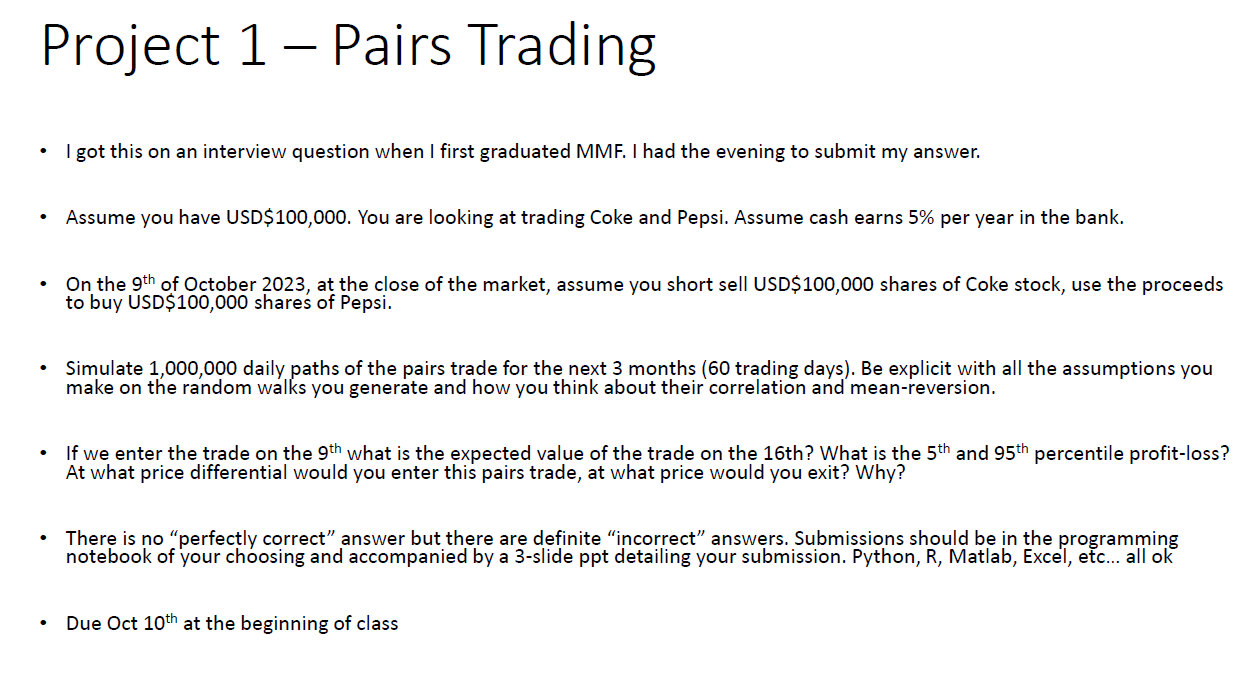

### Approaches:
1. Simulate with ratio between the stock, for pairs trading. (Mean reversion)
2. Simulate stock A and stock B directly (Geometric Brownian motion), then use the rho to connect the two time series together. 
3. ...

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from math import prod
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from datetime import date
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LinearRegression
import math

In [2]:
def trend_tests(y, adf_reg='c'):
    #Trend and unit root test, to see if need detrend or others
    y = y.dropna()

    t = np.arange(len(y))
    X = sm.add_constant(t)
    ols = sm.OLS(y.values, X).fit()
    beta1, p_trend = ols.params[1], ols.pvalues[1]

    adf_stat, adf_p, *_ = adfuller(y.values, regression=adf_reg, autolag='AIC')
    if (adf_p>0.05) or (p_trend<=0.05):
        print('This time series need treatment to make it become white noise')
    else:
        print('This time series is white noise and ready to be similated')

    return {
        "trend check": float(p_trend),
        "adf_p": float(adf_p)
    }

def estimate_ou_equal_spacing(r, dt):
    r = np.asarray(r, float)
    r_lag = r[:-1]
    r_now = r[1:]

    X = sm.add_constant(r_lag)
    res = sm.OLS(r_now, X).fit()
    c, phi = res.params
    s2_eps = res.mse_resid  

    a = -np.log(phi)/dt # Speed
    b = c / (1.0 - phi) # long term Mean
    sigma = np.sqrt( (2.0 * a * s2_eps) / (1.0 - phi**2) ) ## volatility

    return a, b, sigma

In [3]:
n_year = 1
n_month = 12
n_day = 252

### 1. Pull one year daily price data
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)
tickers = ["KO", "PEP"]

raw = yf.download(tickers, start=start, end=end, auto_adjust=False,progress=False)
prices = raw["Adj Close"].copy()
KO_current_price = prices['KO'][-1] ### Current price of KO
pep_current_price = prices['PEP'][-1] ### Current price of PEP

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\651809385.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  KO_current_price = prices['KO'][-1] ### Current price of KO
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\651809385.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pep_current_price = prices['PEP'][-1] ### Current price of PEP


In [4]:
out_sample_start_date = '2023-10-09'
out_sample_end_date = '2024-01-10'
oos_data = prices[(prices.index<= out_sample_end_date) & (prices.index>= out_sample_start_date)][:60]

In [5]:
in_sample_end_date = '2023-10-09'
in_sample_start_date = '2018-10-09'
sample_period_realized_dt = prices[(prices.index<= in_sample_end_date) & (prices.index>= in_sample_start_date)]
rho =sample_period_realized_dt['KO'].corr(sample_period_realized_dt['PEP'])
spread = sample_period_realized_dt['PEP']- sample_period_realized_dt['KO']
ratio = sample_period_realized_dt['PEP']/ sample_period_realized_dt['KO']

In [6]:
out_sample_start_date = '2023-10-09'
out_sample_end_date = '2024-01-10'
oos_data = prices[(prices.index<= out_sample_end_date) & (prices.index>= out_sample_start_date)][:60]

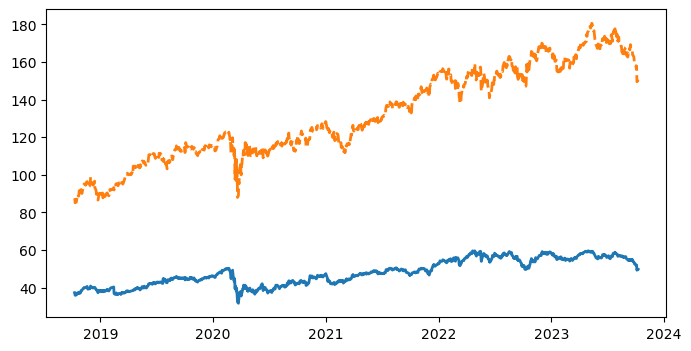

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(sample_period_realized_dt.index, sample_period_realized_dt['KO'], label='KO', linewidth=2)
plt.plot(sample_period_realized_dt.index, sample_period_realized_dt['PEP'], label='PEP', linewidth=2, linestyle='--')

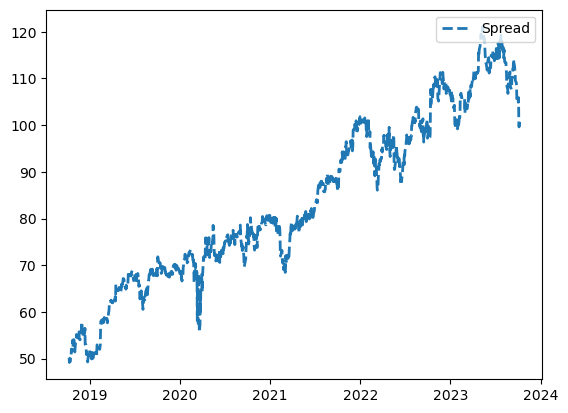

In [8]:
plt.plot(spread.index, spread.values, label='Spread', linewidth=2, linestyle='--')
plt.legend(loc='upper right')

In [9]:
X = sm.add_constant(sample_period_realized_dt['KO'])
ols_model = sm.OLS(sample_period_realized_dt['PEP'].tolist(), X).fit()
c, beta = ols_model.params
sample_period_realized_dt['spread'] = sample_period_realized_dt['PEP'] - beta*sample_period_realized_dt['KO']

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\4096027008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_period_realized_dt['spread'] = sample_period_realized_dt['PEP'] - beta*sample_period_realized_dt['KO']


In [10]:
### Spread
X = sm.add_constant(sample_period_realized_dt['KO'])
ols_model = sm.OLS(sample_period_realized_dt['PEP'].tolist(), X).fit()
c, beta = ols_model.params
sample_period_realized_dt['spread'] = sample_period_realized_dt['PEP'] - beta*sample_period_realized_dt['KO']


#### Detrend
sample_period_realized_dt['t'] = list(range(sample_period_realized_dt.shape[0]))
X = sm.add_constant( sample_period_realized_dt['t'])
model = sm.OLS(list(sample_period_realized_dt['spread']), X).fit()
c_detrend, beta_detrend = model.params
sample_period_realized_dt['detrend_spread'] = sample_period_realized_dt['spread'] - c_detrend - sample_period_realized_dt['t']*beta_detrend

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\825356989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_period_realized_dt['spread'] = sample_period_realized_dt['PEP'] - beta*sample_period_realized_dt['KO']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\825356989.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_period_realized_dt['t'] = list(range(sample_period_realized_dt.shape[0]))
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\825356989.py:13: SettingWithCopyWarning: 
A val

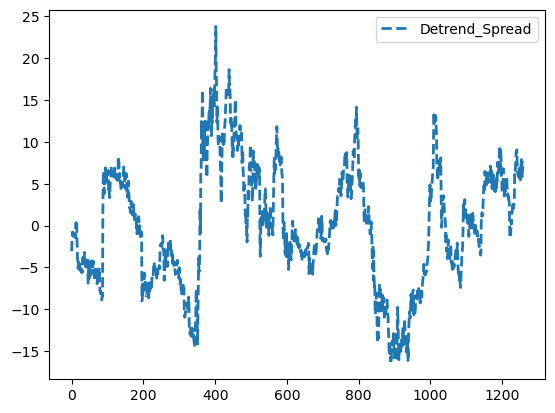

In [11]:
plt.plot(sample_period_realized_dt['t'],sample_period_realized_dt['detrend_spread'], label='Detrend_Spread', linewidth=2, linestyle='--')
plt.legend(loc='upper right')

In [12]:
trend_tests(sample_period_realized_dt['detrend_spread'])

This time series is white noise and ready to be similated


{'trend check': 0.99999999999998, 'adf_p': 0.03478421261870864}

In [13]:
sample_period_realized_dt['detrend_spread'].mean()

np.float64(1.5453457273764978e-14)

### GBM Process: KO and Pepsi

In [284]:
sample_period_realized_dt['log_KO'] = np.log(sample_period_realized_dt['KO'])
ko_return =  sample_period_realized_dt['log_KO'].diff().dropna()
ko_mean = ko_return.mean()
ko_sigma = np.std(ko_return)
corr_matrix = sample_period_realized_dt[['KO','PEP']].corr(method='pearson')

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28868\3441481829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_period_realized_dt['log_KO'] = np.log(sample_period_realized_dt['KO'])


In [285]:
corr_matrix = sample_period_realized_dt[['KO','PEP']].corr(method='pearson')
hisorical_price = sample_period_realized_dt[['KO','PEP']]

In [133]:
cholesky_matrix = np.linalg.cholesky(corr_matrix)
one_trail = np.random.normal(0,1,size=(2, 60))
correlated_trail =  cholesky_matrix @ one_trail
return_mu = hisorical_price.mean()
dat_std = hisorical_price.std()
delta_t = 1
r = pd.DataFrame(dat_std.to_numpy().reshape(-1, 1) *  correlated_trail) + pd.DataFrame(np.tile((return_mu * delta_t).to_numpy(), (60, 1)) ).T

In [341]:
class simulate_GBM_Process_correlated:
    def __init__(self, mu, sigma, n_days, n_trail, historical_dat, correlated = True):
        '''
        correlation = True, then the stock simulated here are correlated, and need to use the cholesky decomposition to correlated to it
        '''
        self.mu =mu
        self.sigma = sigma
        self.n_days = n_days
        self.n_trail = n_trail
        self.historical_dat = historical_dat   
        self.historical_ret = self.historical_dat.diff()/self.historical_dat
        self.historical_ret = self.historical_ret.dropna()
        if correlated == True:
            self.corr_matrix = self.historical_dat.corr(method='pearson')
        else:
            self.corr_matrix = [[1,0],
                               [0,1]
                               ]
            
        self.cholesky_matrix = np.linalg.cholesky(self.corr_matrix)
        self.sim_result = self.sim_return()

    def sim_return(self):
        agg_trail_result = []
        for i in range(self.n_trail):
            one_trail = np.random.normal(self.mu , self.sigma, size=(self.historical_dat.shape[1],  self.n_days ) )
            correlated_trail = self.cholesky_matrix @ one_trail
            return_mu = self.historical_ret.mean()
            dat_std = self.historical_ret.std()
            delta_t = 1 #1/self.n_days
            r = pd.DataFrame(dat_std.to_numpy().reshape(-1, 1) *  correlated_trail) + pd.DataFrame(np.tile((return_mu * delta_t).to_numpy(), (60, 1)) ).T  
            
            r['label'] = self.historical_dat.columns.tolist()
            agg_trail_result.append(r)
        #agg_trail_result = pd.DataFrame(agg_trail_result).reset_index(drop = True)
        output = pd.concat(agg_trail_result).reset_index(drop = True)
        output.index = output['label']
        output = output.drop(columns='label')
        output = (output+1).cumprod(axis=1) 
        return output

    def generate_step_plot(self):
        self.sim_return_result.T.plot(legend=False, title='Stock Price Walk')
        plt.xlabel('Time Step')
        plt.ylabel('Random Walk Value')
        plt.show()
    

In [703]:
historical_data = sample_period_realized_dt[['KO', 'PEP']]
n_days = 60
n_trail = 100000
ko_stock_simulation = simulate_GBM_Process_correlated(0, 1, n_days, n_trail, historical_data, correlated= True )
output = ko_stock_simulation.sim_result
ko_forecast = output.loc[['KO']]*49.795895
ko_forecast.insert(0, 'Start', 49.795895)
pep_forecat = output.loc[['PEP']]*150.666733
pep_forecat.insert(0, 'Start', 150.666733)

ko_stock_simulation = simulate_GBM_Process_correlated(0, 1, n_days, n_trail, historical_data, correlated= False )
output = ko_stock_simulation.sim_result
ko_forecast_uncor = output.loc[['KO']]*49.795895
ko_forecast_uncor.insert(0, 'Start', 49.795895)
pep_forecat_uncor = output.loc[['PEP']]*150.666733
pep_forecat_uncor.insert(0, 'Start', 150.666733)
spread_corr = pd.DataFrame(np.array(pep_forecat) - np.array(ko_forecast))
spread_no_corr = pd.DataFrame(np.array(pep_forecat_uncor) - np.array(ko_forecast_uncor))

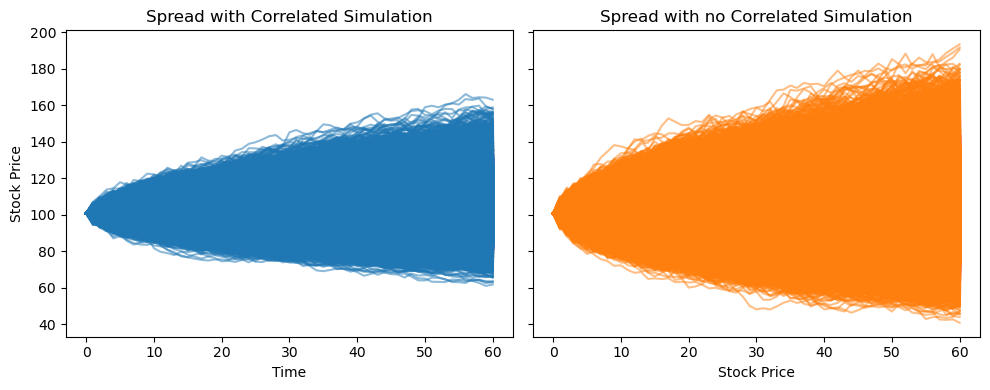

In [704]:
# 1 row × 2 columns, shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

spread_corr.T.plot(ax=axes[0], legend=False, title='Spread with Correlated Simulation', color='tab:blue', alpha=0.5)
axes[0].set_title('Spread with Correlated Simulation')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Stock Price')

spread_no_corr.T.plot(ax=axes[1], legend=False, title='Spread with no Correlated Simulation', color='tab:orange', alpha=0.5)
axes[1].set_title('Spread with no Correlated Simulation')
axes[1].set_xlabel('Stock Price')

plt.tight_layout()
plt.show()

In [705]:
beta_adjusted_spread_correlated = pd.DataFrame(np.array(pep_forecat) - np.array(ko_forecast) * beta)
beta_adjusted_spread_uncorrelated = pd.DataFrame(np.array(pep_forecat_uncor) - np.array(ko_forecast_uncor) * beta)

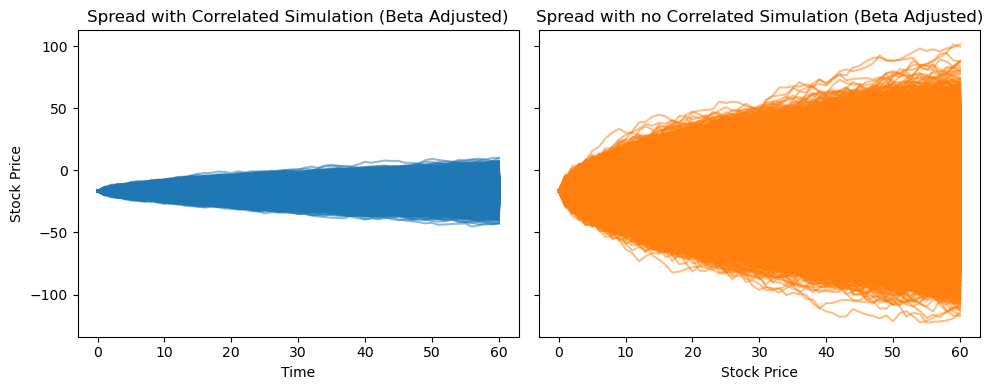

In [706]:
# 1 row × 2 columns, shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

beta_adjusted_spread_correlated.T.plot(ax=axes[0], legend=False, title='Spread with Correlated Simulation (Beta Adjusted)', color='tab:blue', alpha=0.5)
axes[0].set_title('Spread with Correlated Simulation (Beta Adjusted)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Stock Price')

beta_adjusted_spread_uncorrelated.T.plot(ax=axes[1], legend=False, title='Spread with no Correlated Simulation (Beta Adjusted)', color='tab:orange', alpha=0.5)
axes[1].set_title('Spread with no Correlated Simulation (Beta Adjusted)')
axes[1].set_xlabel('Stock Price')

plt.tight_layout()
plt.show()

### Step3 PnL
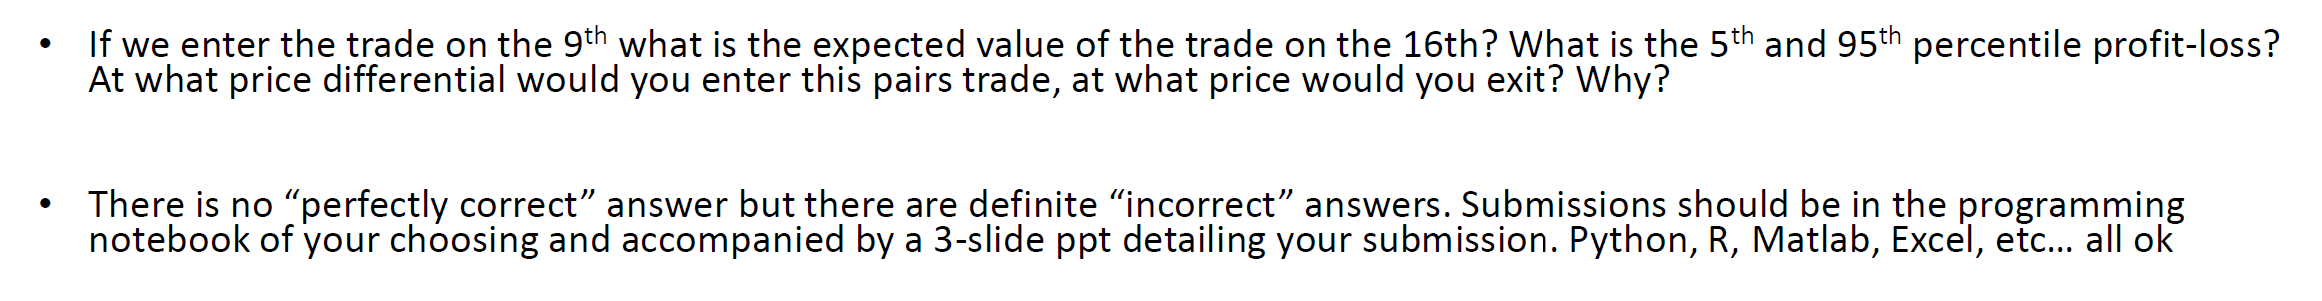

In [707]:
ko_forecast.columns = [i for i in range( ko_forecast.shape[1] ) ]
pep_forecat.columns = [i for i in range( pep_forecat.shape[1] ) ]

-19.093751061966167 -1831.9376780487655 1776.8595408174297


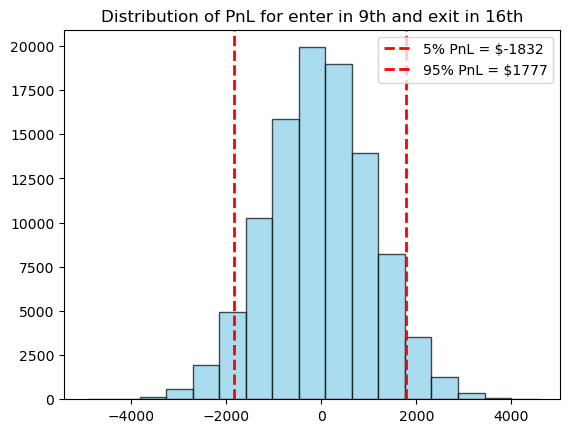

In [715]:
princeple = 100000
n_coke = math.floor( princeple/49.795887 )
n_pepsi = math.floor( princeple/150.666748 )

start = '2023-10-09'
end = '2023-10-16'

# Business days (Mon–Fri)
n_days_interval = pd.bdate_range(start=start, end=end).size

###
pnl_trade1 = np.array(ko_forecast[6]* n_coke) - np.array(pep_forecat[n_days_interval]* n_pepsi)
n_bins = int(1 + np.log2(n_trail))
pnl_trade1 =  np.sort(pnl_trade1)
five_percent_pnl = pnl_trade1[round(0.05* n_trail)]
nighty5_pnl = pnl_trade1[round(0.95* n_trail)]
print(np.mean(pnl_trade1),five_percent_pnl,  nighty5_pnl)


plt.hist(pnl_trade1, bins=n_bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of PnL for enter in 9th and exit in 16th')
plt.axvline(x=five_percent_pnl, color='red', linestyle='--', linewidth=2, label=f'5% PnL = ${round(five_percent_pnl)}')
plt.axvline(x=nighty5_pnl, color='red', linestyle='--', linewidth=2, label=f'95% PnL = ${round(nighty5_pnl)}')
plt.legend()

### Step4: When to In and Out

In [738]:
mean_lst = []
std_lst = []
for i in range(beta_adjusted_spread_correlated.shape[0]):
    dat = beta_adjusted_spread_correlated.iloc[i,]
    mean_lst.append( dat.mean() )
    std_lst.append( dat.std() )

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28868\344472802.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


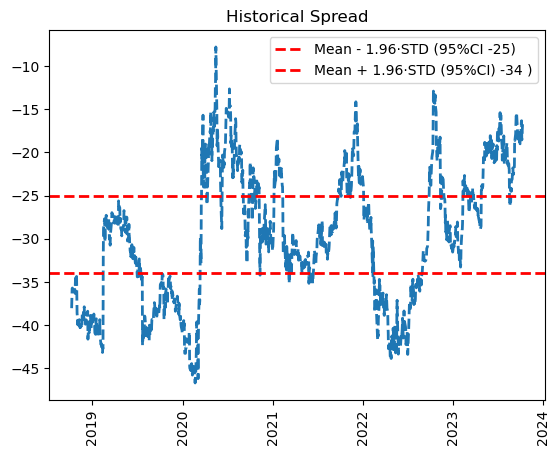

In [793]:
lower_CI = round( sample_period_realized_dt['spread'].mean() + 1.96*np.mean(std_lst) )
upper_CI = round( sample_period_realized_dt['spread'].mean() - 1.96*np.mean(std_lst) )
ins_dat = oos_data['PEP'] - oos_data['KO'] * beta 

plt.plot(sample_period_realized_dt['spread'].index,sample_period_realized_dt['spread'], linewidth=2, linestyle='--')
plt.legend(loc='upper right')

plt.axhline(y=lower_CI, color='red', linestyle='--', linewidth=2, label=f'Mean - 1.96·STD (95%CI {lower_CI})')
plt.axhline(y=upper_CI, color='red', linestyle='--', linewidth=2, label=f'Mean + 1.96·STD (95%CI) {upper_CI} )')
plt.title('Historical Spread') 
plt.xticks(rotation=90)
plt.legend()

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28868\3214907608.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


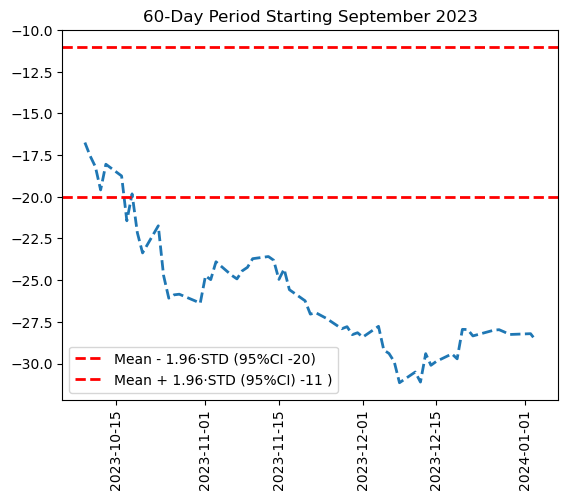

In [791]:
lower_CI = round( np.mean(mean_lst)  - 1.96*np.mean(std_lst) )
upper_CI = round( np.mean(mean_lst)  + 1.96*np.mean(std_lst) )
ins_dat = oos_data['PEP'] - oos_data['KO'] * beta 

plt.plot(ins_dat.index,ins_dat, linewidth=2, linestyle='--')
plt.legend(loc='upper right')

plt.axhline(y=lower_CI, color='red', linestyle='--', linewidth=2, label=f'Mean - 1.96·STD (95%CI {lower_CI})')
plt.axhline(y=upper_CI, color='red', linestyle='--', linewidth=2, label=f'Mean + 1.96·STD (95%CI) {upper_CI} )')
plt.title('60-Day Period Starting September 2023') 
plt.xticks(rotation=90)
plt.legend()

### Pairs Trading PnL

In [355]:
class pairs_trading_pnl:
    def __init__(self,price_data, lower_cut, upper_cut, mu, principle ):
        self.price_data = price_data
        self.lower_cut = lower_cut
        self.upper_cut = upper_cut
        self.price_data['lower_cut'] = lower_cut
        self.price_data['upper_cut'] = upper_cut
        self.price_data['mean'] = mu
        self.principle = principle
        self.price_data_in_out,self.trading_record = self.in_out_point()
        self.upd_price_data_in_out,self.upd_trading_record = self.backtesting()
        self.evaluation_metric = pd.DataFrame(self.excute_pnl_evaluation()).T
        
        

    def in_out_point(self):
        df = self.price_data.copy()
        df["cross_lower"] = (df["spread"].shift(1) > df["lower_cut"].shift(1)) & (df["spread"] <= df["lower_cut"])
        df["cross_upper"] = (df["spread"].shift(1) < df["upper_cut"].shift(1)) & (df["spread"] >= df["upper_cut"])
        df["cross_mean"]  = ((df["spread"].shift(1) < df["mean"].shift(1)) & (df["spread"] >= df["mean"])) | \
                            ((df["spread"].shift(1) > df["mean"].shift(1)) & (df["spread"] <= df["mean"]))
        
        # Label the type of crossing
        df["cross_signal"] = df.apply(
            lambda x: "Crossed Lower" if x["cross_lower"]
            else ("Crossed Upper" if x["cross_upper"]
            else ("Crossed Mean" if x["cross_mean"] else "")),
            axis=1
        )
        
        # Filter only the crossover events
        df["PEP_in"] = 0
        current = 0        # current position (+1/-1/0)
        flipped = False    # flipped since last band signal?
        
        current_lst = []
        for i, row in df.iterrows():
            # band signals reset regime
            if row["cross_lower"]:
                current = 1
                df.at[i, "PEP_in"] = current
                flipped = False
                continue
            if row["cross_upper"]:
                current = -1
                df.at[i, "PEP_in"] = current
                flipped = False
                continue
        
            # flip on first cross_mean only if we have an active sign and not flipped yet
            if row["cross_mean"] and current != 0 and not flipped:
                current = current*-1
                df.at[i, "PEP_in"] = current
                flipped = True
            # else stays 0 for non-event rows
        
        df["PEP_in"] = df["PEP_in"].astype(int)
        
        sig = df["PEP_in"].astype(int).values
        compressed = []
        
        for i, val in enumerate(sig):
            if val == 0:
                compressed.append(0)
                continue
        
            # look at the last two kept non-zero values
            recent_nonzero = [x for x in compressed if x != 0][-2:]
        
            # if the last two are identical and current repeats → drop it
            if len(recent_nonzero) == 2 and val == recent_nonzero[-1] == recent_nonzero[-2]:
                compressed.append(0)
            else:
                compressed.append(val)
        
        df["PEP_in"] = compressed
        df["KO_in"] = 0
        df.loc[df["PEP_in"] == 1, 'KO_in'] = -1
        df.loc[df["PEP_in"] == -1, 'KO_in'] = 1
    
        ###### above is reversed, flip all back
        df['PEP_in'] = df['PEP_in'] * -1
        df['KO_in'] = df['KO_in'] * -1
    
        
        trading_information = df[df['PEP_in']!=0]
        complete_trade_num = math.floor(trading_information.shape[0]/2)*2
        trading_information['PEP_trade_num'] =self.principle* trading_information['PEP_in']/trading_information['PEP']
       # trading_information['PEP_trade_num'] = trading_information['PEP_trade_num'].apply(lambda x: math.floor(x) )
        
        trading_information['KO_trade_num'] =self.principle* trading_information['KO_in']/trading_information['KO']
        #trading_information['KO_trade_num'] = trading_information['KO_trade_num'].apply(lambda x: math.floor(x) )
        trading_information = trading_information.iloc[:complete_trade_num, ]
        return df, trading_information

    def backtesting(self):
        price_data_in_out = self.price_data_in_out.copy()
        trading_record = self.trading_record.copy()
        price_data_in_out = pd.merge(price_data_in_out, trading_record[['PEP_trade_num','KO_trade_num']], left_index=True, right_index=True, how='left')
        price_data_in_out = price_data_in_out.fillna(0)
        
        complete_trade_num = math.floor(trading_record.shape[0]/2)
        trade_order = [i for i in range(complete_trade_num) ]*2
        trade_order.sort()
        trading_record['trade_order'] = trade_order
        
        #trading_actual_information = 
        for k in trading_record['trade_order'].unique():
            single_trade = trading_record[trading_record['trade_order']== k]
            start_dt = single_trade.index[0]
            end_dt = single_trade.index[1]
            pep_in = single_trade[single_trade.index == start_dt]['PEP_trade_num'].values[0]
            ko_in = single_trade[single_trade.index == start_dt]['KO_trade_num'].values[0]
            
            pep_out = -pep_in
            ko_out = -ko_in
            price_data_in_out.loc[(price_data_in_out.index> start_dt) &(price_data_in_out.index< end_dt) , 'PEP_trade_num' ] = pep_in
            price_data_in_out.loc[(price_data_in_out.index> start_dt) &(price_data_in_out.index< end_dt), 'KO_trade_num'] = ko_in
        
            price_data_in_out.loc[(price_data_in_out.index== end_dt) , 'PEP_trade_num' ] = pep_out
            price_data_in_out.loc[(price_data_in_out.index== end_dt), 'KO_trade_num'] = ko_out
        
        trading_record = price_data_in_out[price_data_in_out.index.isin(trading_record.index)]
        price_data_in_out['Daily_PnL'] = price_data_in_out['PEP']* price_data_in_out['PEP_trade_num'] + price_data_in_out['KO']* price_data_in_out['KO_trade_num']
        trading_record['Excute_PnL'] = trading_record['PEP']* trading_record['PEP_trade_num'] + trading_record['KO']* trading_record['KO_trade_num']

        return price_data_in_out, trading_record

    def excute_pnl_evaluation(self):
        #### Set trading cost = 15 basis point
        
        trading_cost_per_trade = self.principle*0.0015*2
        trade_pnl = self.upd_trading_record['Excute_PnL'] - trading_cost_per_trade
        trade_pnl = trade_pnl[trade_pnl != 0]  # keep only completed trades
        
        # --- compute trade-level statistics
        wins = trade_pnl[trade_pnl > 0]
        losses = trade_pnl[trade_pnl < 0]
        
        win_rate = len(wins) / len(trade_pnl)
        avg_win = wins.mean()
        avg_loss = losses.mean()
        profit_factor = wins.sum() / abs(losses.sum()) if len(losses) > 0 else np.nan
        expectancy = trade_pnl.mean()
        max_win = trade_pnl.max()
        max_loss = trade_pnl.min()
        cum_pnl = trade_pnl.cumsum() 
        
        # --- compute equity curve & drawdown
        equity = trade_pnl.cumsum()
        running_max = equity.cummax()
        drawdown = equity - running_max
        max_dd = drawdown.min()
        max_dd_pct = (drawdown / running_max).min()
        
        report = pd.Series({
            'Trades': len(trade_pnl),
            'Win Rate': win_rate,
            'Avg Win': avg_win,
            'Avg Loss': avg_loss,
            'Profit Factor': profit_factor,
            'Expectancy': expectancy,
            'Max Win': max_win,
            'Max Loss': max_loss,
            'Cumulative PnL': trade_pnl.sum(),
            'Max Drawdown': max_dd,
            'Max Drawdown %': max_dd_pct,
        })
        return report

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\655193682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['lower_cut'] = lower_cut
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\655193682.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


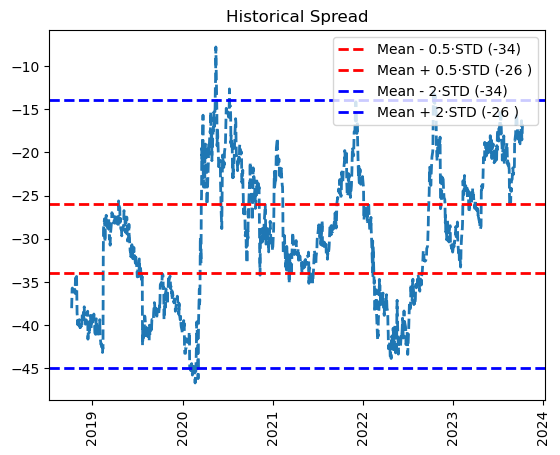

In [378]:
lower_cut = inner_range[0]
upper_cut = inner_range[1]

price_data = sample_period_realized_dt[['KO','PEP','spread']]
price_data['lower_cut'] = lower_cut
price_data['upper_cut'] = upper_cut
price_data['mean'] = sample_period_realized_dt['spread'].mean()
principle = 100000

mu = sample_period_realized_dt['spread'].mean()
sigma = sample_period_realized_dt['spread'].std()
inner_range = [mu - 0.5* sigma, mu+0.5*sigma]
upper_range = [mu - 2* sigma, mu+2*sigma]


lower_CI = round( inner_range[0])
upper_CI = round( inner_range[1])

lower_CI_wide = round( upper_range[0])
upper_CI_wide = round( upper_range[1])

plt.plot(sample_period_realized_dt['spread'].index,sample_period_realized_dt['spread'], linewidth=2, linestyle='--')
plt.legend(loc='upper right')

plt.axhline(y=lower_CI, color='red', linestyle='--', linewidth=2, label=f'Mean - 0.5·STD ({lower_CI})')
plt.axhline(y=upper_CI, color='red', linestyle='--', linewidth=2, label=f'Mean + 0.5·STD ({upper_CI} )')
plt.axhline(y=lower_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean - 2·STD ({lower_CI})')
plt.axhline(y=upper_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean + 2·STD ({upper_CI} )')

plt.title('Historical Spread') 
plt.xticks(rotation=90)
plt.legend()

In [383]:
inner_range_lst = np.linspace(0.5, 2, 16)
inner_range = [mu - ci* sigma, mu+ci*sigma]


In [398]:
evaluation_metric_lst = []
for ci in inner_range_lst:
    inner_range = [mu - ci* sigma, mu+ci*sigma]
    lower_cut = inner_range[0]
    upper_cut = inner_range[1]
    
    pairs_trading_evaluation = pairs_trading_pnl(price_data, lower_cut, upper_cut, mu, principle)
    
    evaluation_metric = pairs_trading_evaluation.evaluation_metric
    price_data_in_out = pairs_trading_evaluation.upd_price_data_in_out
    daily_pnl = price_data_in_out[price_data_in_out['Daily_PnL']!= 0 ]
    
    daily_pnl_mean = daily_pnl['Daily_PnL'].mean()
    daily_pnl_std = daily_pnl['Daily_PnL'].std()
    
    evaluation_metric['daily_PnL_mean'] = daily_pnl_mean
    evaluation_metric['daily_PnL_median'] = daily_pnl['Daily_PnL'].median()
    evaluation_metric['daily_PnL_std'] = daily_pnl_std
    evaluation_metric['daily_PnL_lower_CI'] = int(daily_pnl_mean-1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
    evaluation_metric['daily_PnL_upper_CI'] = int(daily_pnl_mean+1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
    
    evaluation_metric['threhold'] = ci
    evaluation_metric_lst.append(evaluation_metric)

evaluation_metric = pd.concat(evaluation_metric_lst).reset_index(drop = True)
evaluation_metric.index = evaluation_metric['threhold']

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['PEP_trade_num'] =self.principle* trading_information['PEP_in']/trading_information['PEP']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['KO_trade_num'] =self.principle* trading_information['KO_in']/trading_information['KO']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:125:

In [401]:
evaluation_metric

,Trades,Win Rate,Avg Win,Avg Loss,Profit Factor,Expectancy,Max Win,Max Loss,Cumulative PnL,Max Drawdown,Max Drawdown %,daily_PnL_mean,daily_PnL_median,daily_PnL_std,daily_PnL_lower_CI,daily_PnL_upper_CI,threhold
threhold,,,,,,,,,,,,,,,,,
0.5,26.0,0.384615,2289.392672,-801.795894,1.784582,387.122785,4964.093354,-4325.193975,10065.192417,-10128.734306,-1.181250,2357.181882,1973.598144,2939.674981,-3404,8118,0.5
0.6,24.0,0.250000,5242.701695,-915.353730,1.909171,624.160126,7925.480164,-4110.147756,14979.843030,-10443.560868,-0.760267,807.173608,527.109144,1973.222011,-3060,4674,0.6
0.7,22.0,0.409091,4968.266895,-532.207260,6.462838,1717.986712,7925.480164,-3512.381616,37795.707669,-4112.381616,-0.339317,320.049987,317.173122,2557.371634,-4692,5332,0.7
0.8,22.0,0.318182,4972.575438,-821.199638,2.825787,1022.274250,7556.320356,-4089.253815,22490.033492,-10086.644549,-0.695311,1125.048466,1083.889038,2659.427816,-4087,6337,0.8
0.9,22.0,0.409091,5124.948565,-621.166658,5.711899,1729.516842,8511.050122,-3512.381616,38049.370522,-4112.381616,-0.450628,-242.204001,121.736402,2677.065281,-5489,5004,0.9
1.0,20.0,0.300000,6538.392215,-1147.035266,2.442966,1158.592978,8426.716000,-4510.630123,23171.859560,-10746.112115,-0.373192,-558.708750,-726.458664,2080.440756,-4636,3518,1.0
1.1,20.0,0.400000,5861.385799,-359.206493,10.878396,2129.030424,9676.605696,-1210.910633,42580.608478,-1510.910633,-0.165626,75.304694,194.610121,2771.314702,-5356,5507,1.1
1.2,18.0,0.333333,6718.022604,-1159.796941,2.896206,1466.142907,10991.561295,-6036.006335,26390.572332,-12417.563290,-0.385808,-446.895885,-507.047131,3255.939657,-6828,5934,1.2
1.3,18.0,0.333333,6860.740452,-1498.435892,2.289301,1287.956223,10991.561295,-8035.710801,23183.212012,-16481.230699,-0.555807,-331.888383,-411.247115,3487.234453,-7166,6503,1.3


C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\1835793165.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


Text(0.5, 1.0, 'In Sample Data Pairs Trading')

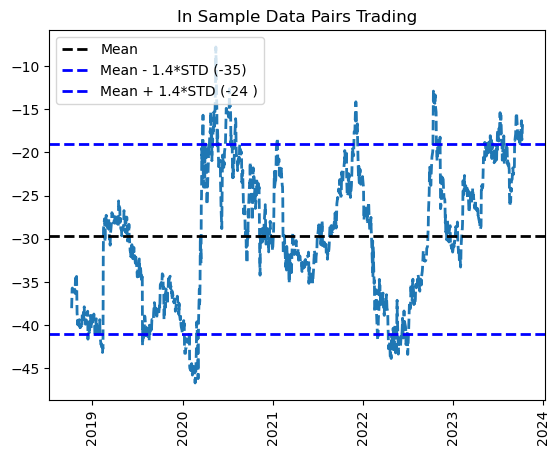

In [422]:
inner_range = [mu - 0.7* sigma, mu+0.7*sigma]
upper_range = [mu - 1.4* sigma, mu+1.4*sigma]


lower_CI = round( inner_range[0])
upper_CI = round( inner_range[1])

lower_CI_wide = round( upper_range[0])
upper_CI_wide = round( upper_range[1])

plt.plot(sample_period_realized_dt['spread'].index,sample_period_realized_dt['spread'], linewidth=2, linestyle='--')
plt.legend(loc='upper right')

#plt.axhline(y=lower_CI, color='red', linestyle='--', linewidth=2, label=f'Mean - 0.7*STD ({lower_CI})')
#plt.axhline(y=upper_CI, color='red', linestyle='--', linewidth=2, label=f'Mean + 0.7*STD ({upper_CI} )')
plt.axhline(y=mu, color='black', linestyle='--', linewidth=2, label=f'Mean')

plt.axhline(y=lower_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean - 1.4*STD ({lower_CI})')
plt.axhline(y=upper_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean + 1.4*STD ({upper_CI} )')

plt.title('Historical Spread') 
plt.xticks(rotation=90)
plt.legend()
plt.title('In Sample Data Pairs Trading')

### Check the future data

In [416]:
ci = 1.4
inner_range = [mu - ci* sigma, mu+ci*sigma]
lower_cut = inner_range[0]
upper_cut = inner_range[1]

pairs_trading_evaluation = pairs_trading_pnl(oos_data, lower_cut, upper_cut, mu, principle)


evaluation_metric = pairs_trading_evaluation.evaluation_metric
price_data_in_out = pairs_trading_evaluation.upd_price_data_in_out
daily_pnl = price_data_in_out[price_data_in_out['Daily_PnL']!= 0 ]

daily_pnl_mean = daily_pnl['Daily_PnL'].mean()
daily_pnl_std = daily_pnl['Daily_PnL'].std()

evaluation_metric['daily_PnL_mean'] = daily_pnl_mean
evaluation_metric['daily_PnL_median'] = daily_pnl['Daily_PnL'].median()
evaluation_metric['daily_PnL_std'] = daily_pnl_std
evaluation_metric['daily_PnL_lower_CI'] = int(daily_pnl_mean-1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
evaluation_metric['daily_PnL_upper_CI'] = int(daily_pnl_mean+1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
evaluation_metric

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['PEP_trade_num'] =self.principle* trading_information['PEP_in']/trading_information['PEP']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['KO_trade_num'] =self.principle* trading_information['KO_in']/trading_information['KO']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:125:

,Trades,Win Rate,Avg Win,Avg Loss,Profit Factor,Expectancy,Max Win,Max Loss,Cumulative PnL,Max Drawdown,Max Drawdown %,daily_PnL_mean,daily_PnL_median,daily_PnL_std,daily_PnL_lower_CI,daily_PnL_upper_CI
0,2.0,0.5,6184.437717,-300.0,20.614792,2942.218859,6184.437717,-300.0,5884.437717,0.0,0.0,-3649.970638,-3751.475404,2146.028707,-7856,556


In [417]:
ci = 0.7
inner_range = [mu - ci* sigma, mu+ci*sigma]
lower_cut = inner_range[0]
upper_cut = inner_range[1]

pairs_trading_evaluation = pairs_trading_pnl(oos_data, lower_cut, upper_cut, mu, principle)


evaluation_metric = pairs_trading_evaluation.evaluation_metric
price_data_in_out = pairs_trading_evaluation.upd_price_data_in_out
daily_pnl = price_data_in_out[price_data_in_out['Daily_PnL']!= 0 ]

daily_pnl_mean = daily_pnl['Daily_PnL'].mean()
daily_pnl_std = daily_pnl['Daily_PnL'].std()

evaluation_metric['daily_PnL_mean'] = daily_pnl_mean
evaluation_metric['daily_PnL_median'] = daily_pnl['Daily_PnL'].median()
evaluation_metric['daily_PnL_std'] = daily_pnl_std
evaluation_metric['daily_PnL_lower_CI'] = int(daily_pnl_mean-1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
evaluation_metric['daily_PnL_upper_CI'] = int(daily_pnl_mean+1.96*daily_pnl_std) #(int(daily_pnl_mean-1.96*daily_pnl_std), int(daily_pnl_mean+1.96*daily_pnl_std))
evaluation_metric

C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['PEP_trade_num'] =self.principle* trading_information['PEP_in']/trading_information['PEP']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_information['KO_trade_num'] =self.principle* trading_information['KO_in']/trading_information['KO']
C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\585506290.py:125:

,Trades,Win Rate,Avg Win,Avg Loss,Profit Factor,Expectancy,Max Win,Max Loss,Cumulative PnL,Max Drawdown,Max Drawdown %,daily_PnL_mean,daily_PnL_median,daily_PnL_std,daily_PnL_lower_CI,daily_PnL_upper_CI
0,2.0,0.0,NaN,-356.593308,0.0,-356.593308,-300.0,-413.186617,-713.186617,-413.186617,-0.0,-321.602775,-257.120755,174.77683,-664,20


C:\Users\w28sh\AppData\Local\Temp\ipykernel_28768\2790214242.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


Text(0.5, 1.0, 'Out Of Sample Data')

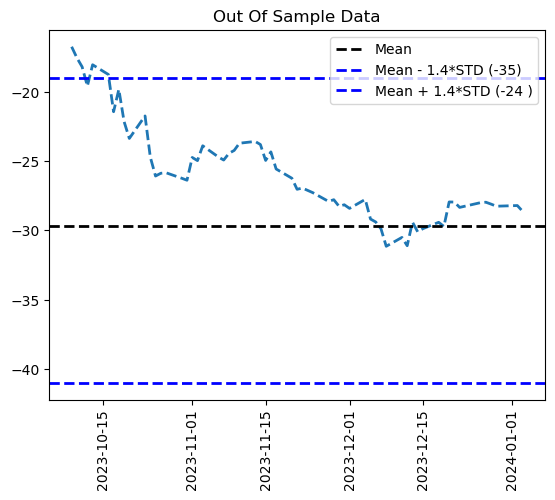

In [424]:
inner_range = [mu - 0.7* sigma, mu+0.7*sigma]
upper_range = [mu - 1.4* sigma, mu+1.4*sigma]


lower_CI = round( inner_range[0])
upper_CI = round( inner_range[1])

lower_CI_wide = round( upper_range[0])
upper_CI_wide = round( upper_range[1])

plt.plot(oos_data['spread'].index,oos_data['spread'], linewidth=2, linestyle='--')
plt.legend(loc='upper right')

#plt.axhline(y=lower_CI, color='red', linestyle='--', linewidth=2, label=f'Mean - 0.7*STD ({lower_CI})')
#plt.axhline(y=upper_CI, color='red', linestyle='--', linewidth=2, label=f'Mean + 0.7*STD ({upper_CI} )')
plt.axhline(y=mu, color='black', linestyle='--', linewidth=2, label=f'Mean')

plt.axhline(y=lower_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean - 1.4*STD ({lower_CI})')
plt.axhline(y=upper_CI_wide, color='blue', linestyle='--', linewidth=2, label=f'Mean + 1.4*STD ({upper_CI} )')

plt.title('Historical Spread') 
plt.xticks(rotation=90)
plt.legend()
plt.title('Out Of Sample Data')
